/tmp/ipykernel_1718/3751563710.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  slope = diff_coord[1] / diff_coord[0]


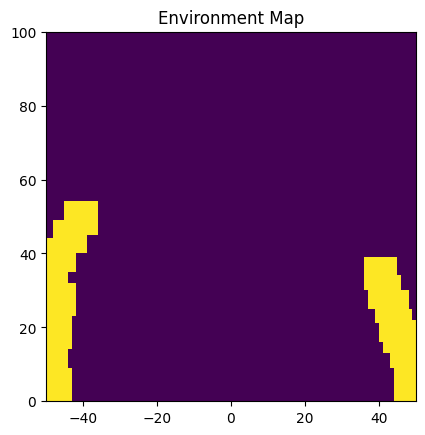

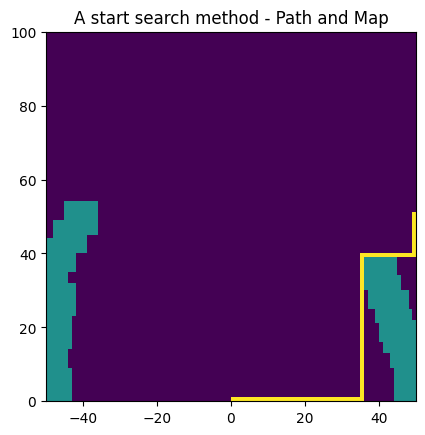

In [58]:
import numpy as np
from queue import PriorityQueue
import matplotlib.pyplot as plt
from picar_4wd.pwm import PWM
from picar_4wd.filedb import FileDB
from picar_4wd.servo import Servo
from picar_4wd.ultrasonic import Ultrasonic
from picar_4wd.pin import Pin
import time
import picar_4wd as fc

Location = tuple[int, int]
# Size of 2D Numpy Array
NP_ARRAY_SIZE = 100

# If below the threshold connect the coordinates
THRESHOLD = 1

SERVO_STEP = 5

# Maximum number of distance trials when -2 is returned
MAX_DISTANCE_READINGS = 3

global TURN_SPEED
global SPEED
global STOP_TIME
global TURN_TIME

SPEED = 20
TURN_SPEED = 30
STOP_TIME = 0.15
TURN_TIME = 1.15

# Config File:
config = FileDB()
ultrasonic_servo_offset = int(config.get("ultrasonic_servo_offset", default_value=0))

us = Ultrasonic(Pin("D8"), Pin("D9"))


servo = Servo(PWM("P0"), offset=ultrasonic_servo_offset)

global ENV_MAP

ENV_MAP = np.zeros((NP_ARRAY_SIZE, NP_ARRAY_SIZE))


def get_distance():
    number_distance_readings = 0
    while number_distance_readings < MAX_DISTANCE_READINGS:
        distance = us.get_distance()
        if distance != -2:
            break
        number_distance_readings += 1
    return distance


def get_dergee_distance():
    
    degree_distance_list = []
    for degree in range(-90, 95, SERVO_STEP):
        servo.set_angle(degree)
        time.sleep(0.3)
        distance = get_distance()
        degree_distance_list.append((degree, distance))
        
    return degree_distance_list

def init_map(degree_distance_list: list) -> list:
    
    global ENV_MAP

    ENV_MAP = np.zeros((NP_ARRAY_SIZE, NP_ARRAY_SIZE))
    
    prev_coord = np.array([-100000, -100000])
    
    for degree, distance in degree_distance_list:
        
        x_val = round(distance*np.cos(np.radians(degree + 90)))
        y_val = round(distance*np.sin(np.radians(degree + 90)))
        
        if abs(x_val) >= 50 or y_val >= 50 or y_val <= 0:
            continue

        
        # Ensuring y indices are within bounds
        for dy in range(-4, 5):  # From y_val - 2 to y_val + 2
            y_index = y_val + dy
            if 0 <= y_index and y_index< NP_ARRAY_SIZE:
                # Ensuring x indices are within bounds
                x_start = max(x_val + 46, 0)  # Ensure x_start is not less than 0
                x_end = min(x_val + 55, NP_ARRAY_SIZE)  # Ensure x_end does not exceed NP_ARRAY_SIZE
                ENV_MAP[y_index, x_start:x_end] = 1

        
        present_coord = np.array([x_val, y_val])
        relative_distance = calculate_distance(prev_coord, present_coord)
        
        if relative_distance <= 4:
            interpolate_map(prev_coord, present_coord)
            
        prev_coord = present_coord
        

def calculate_distance(prev_coord, present_coord):
    return np.linalg.norm(prev_coord - present_coord)
        
def interpolate_map(prev_coord, present_coord):
    diff_coord = prev_coord - present_coord
    slope = diff_coord[1] / diff_coord[0]
    for x in range(min(present_coord[0], prev_coord[0]) + 1, max(present_coord[0], prev_coord[0])):
        y = round(slope * (x - present_coord[0]) + present_coord[1])
        ENV_MAP[y][x + 50] = 1
    
def plot_map():
    x_min, x_max = -50, 50
    y_min, y_max = 0, 100
    extent = [x_min, x_max, y_min, y_max]

    plt.title("Environment Map")
    plt.imshow(ENV_MAP, interpolation="none", extent=extent, origin="lower")
    plt.show()

def heuristic(a: Location, b: Location) -> float:
    (x1, y1) = a
    (x2, y2) = b
    return abs(x1 - x2) + abs(y1 - y2)

def get_neighbors(grid: np.ndarray, current: Location) -> list[Location]:
    (x, y) = current
    neighbors = [(x-1, y), (x+1, y), (x, y-1), (x, y+1)]  # 4-directional movement
    valid_neighbors = [n for n in neighbors if 0 <= n[0] < grid.shape[0] and 0 <= n[1] < grid.shape[1] and grid[n] == 0]
    return valid_neighbors

def a_star_search(grid: np.ndarray, start: Location, goal: Location):
    frontier = PriorityQueue()
    frontier.put((0, start))  # Priority queues require a tuple (priority, item)
    came_from: dict[Location, Location | None] = {}
    cost_so_far: dict[Location, float] = {}
    came_from[start] = None
    cost_so_far[start] = 0
    
    while not frontier.empty():
        current_priority, current = frontier.get()
        
        if current == goal:
            break
        
        for next in get_neighbors(grid, current):
            new_cost = cost_so_far[current] + 1  # Assume a uniform cost of 1 for simplicity
            if next not in cost_so_far or new_cost < cost_so_far[next]:
                cost_so_far[next] = new_cost
                priority = new_cost + heuristic(next, goal)
                frontier.put((priority, next))
                came_from[next] = current
    
    return came_from, cost_so_far

def reconstruct_path(came_from: dict[Location, Location or None], start: Location, goal: Location) -> list[Location]:
    current = goal
    path = []
    while current != start:  # backtrack from goal to start
        path.append(current)
        current = came_from[current]
    path.append(start)  # optional: add start position
    path.reverse()  # optional: reverse the path to start->goal
    return path

def visualize_path(grid: np.ndarray, path: list[Location]):
    # Mark the path in the grid for visualization
    for location in path:
        grid[location] = 2  # Mark the path with 2

    
    x_min, x_max = -50, 50
    y_min, y_max = 0, 100
    extent = [x_min, x_max, y_min, y_max]
    # Plot the grid
    plt.title("A start search method - Path and Map")
    plt.imshow(grid, interpolation='nearest', origin='lower', extent=extent)
    plt.show()
    
def get_directions(path: list) -> list:
    directions = []
    for i in range(1, len(path)):
        current = path[i]
        previous = path[i-1]
        if current[0] == previous[0]:
            if current[1] == previous[1] + 1:
                directions.append('Right')
            else:
                directions.append('Left')
        else:
            if current[0] == previous[0] + 1:
                directions.append('Down')
            else:
                directions.append('Up')
    return directions
    

def navigate_with_path(path: list):
    
    global SPEED
    global STOP_TIME
    global TURN_TIME
    global TURN_SPEED

    prev_direction = path[0]
    if prev_direction == 'Right':
        fc.turn_left(TURN_SPEED)
        time.sleep(TURN_TIME)
    elif prev_direction == 'Left':
        fc.turn_right(TURN_SPEED)
        time.sleep(TURN_TIME)
    for curr_direction in path:
        if prev_direction == curr_direction:
            if prev_direction == "Right" or prev_direction == "Left":
                fc.backward(SPEED)
                time.sleep(0.02)
            else:
                fc.backward(SPEED)
                time.sleep(0.05)
        else:
            if (prev_direction == 'Right' and curr_direction == 'Down') or (prev_direction == 'Left' and curr_direction == 'Up') or (prev_direction == 'Down' and curr_direction == 'Left') or (prev_direction == 'Up' and curr_direction == 'Right'):
                fc.stop()
                time.sleep(STOP_TIME)
                fc.turn_right(TURN_SPEED)
                time.sleep(TURN_TIME)
            elif (prev_direction == 'Right' and curr_direction == 'Up') or (prev_direction == 'Left' and curr_direction == 'Down') or (prev_direction == 'Down' and curr_direction == 'Right') or (prev_direction == 'Up' and curr_direction == 'Left'):
                fc.stop()
                time.sleep(STOP_TIME)
                fc.turn_left(TURN_SPEED)
                time.sleep(TURN_TIME)
            
        prev_direction = curr_direction
            

def main():


    # degree_distance_list = get_dergee_distance()
    # init_map(degree_distance_list)
    # plot_map()
    # servo.set_angle(0)

    global TURN_SPEED
    global SPEED
    run_duration = 15
    turn_time = 1.1
    
    start, goal = (0, 50), (50, 99)
    

    start_time = time.time()
    
    while True:
        
        current_time = time.time()

        if current_time - start_time > run_duration:
            break

        degree_distance_list = get_dergee_distance()
        init_map(degree_distance_list)
        plot_map()
        servo.set_angle(0)
        
        grid = ENV_MAP
        came_from, cost_so_far = a_star_search(grid, start, goal)
        
        path = reconstruct_path(came_from, start, goal)
        directions = get_directions(path)
        visualize_path(grid, path)

        navigate_with_path(directions)
        
        fc.stop()
    
    
if __name__ == "__main__":
    main()

In [43]:
grid = ENV_MAP.copy()

In [44]:
def fill_rectangle(grid, left, right, top, bottom):
    """Fill a rectangular area within the grid with 1s."""
    for x in range(left, right + 1):
        for y in range(bottom, top + 1):
            grid[y, x] = 1

def fuzzify_map(grid):
    visited = np.zeros_like(grid)
    rows, cols = grid.shape
    
    def dfs(x, y, component):
        if x < 0 or x >= cols or y < 0 or y >= rows or visited[y, x] or grid[y, x] == 0:
            return
        visited[y, x] = 1
        component.append((x, y))
        directions = [(0, 1), (1, 0), (0, -1), (-1, 0)]  # 4-directional
        for dx, dy in directions:
            dfs(x + dx, y + dy, component)
    
    for y in range(rows):
        for x in range(cols):
            if grid[y, x] == 1 and not visited[y, x]:
                component = []
                dfs(x, y, component)
                if component:
                    left = min(c[0] for c in component)
                    right = max(c[0] for c in component)
                    top = max(c[1] for c in component)
                    bottom = min(c[1] for c in component)
                    fill_rectangle(grid, left, right, top, bottom)

# After initializing ENV_MAP with sensor data
fuzzify_map(grid)


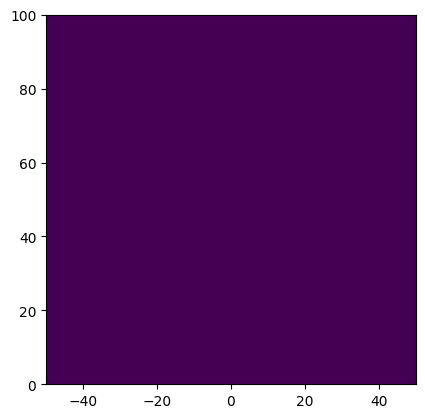

In [45]:
x_min, x_max = -50, 50
y_min, y_max = 0, 100
extent = [x_min, x_max, y_min, y_max]
# Plot the grid
plt.imshow(grid, interpolation='nearest', origin='lower', extent=extent)
plt.show()

In [46]:
np.unique(grid)

array([1.])